# UNET SEGMENTATION

In [1]:
## Imports
import os
import sys
import random
from glob import glob as glob
import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

import matplotlib
import matplotlib.image as Image
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split

tf.config.run_functions_eagerly(True)

## Seeding 
seed = 2019
random.seed = seed
np.random.seed = seed
tf.seed = seed



## Hyperparameters

In [2]:
dim = 224

# get image and mask files
image_files = glob(r'C:\Users\chloe\DE4\Masters\Dataset\Training_Data_1plus\*_i*')
mask_files = glob(r'C:\Users\chloe\DE4\Masters\Dataset\Training_Data_1plus\*_s*')

# splits into test and training datasets
train_imgs, test_imgs, train_masks, test_masks = train_test_split(image_files, mask_files, test_size = 0.33, random_state= 123)

print(len(train_imgs))

batch_size = 32

count = 0
ratios = None

197


## Data Generator

In [3]:

class DataGen(keras.utils.Sequence):
    def __init__(self, image_files, mask_files,  batch_size, hls = False):
        self.img_files = image_files
        self.mask_files = mask_files
        self.batch_size = batch_size
        self.num_files = len(image_files)

        self.hls = hls

        self.current_ratios = None

    def ratio_Imgs(self, masks):
        rs = []
        for i in masks:
            i = np.reshape(i, (dim, dim))

            r = sum(i > 0.5)/ dim **2

            rs.append(r)
        
        self.current_ratios = np.array(rs)
        global ratios
        ratios = self.current_ratios


    def __getitem__(self, index):
        'Returns batch of images and labels'

        this_batch = self.batch_size
        # Changes batch size for final batch (no data missed)
        if(index+1)*self.batch_size > self.num_files:
            this_batch = self.num_files - index*self.batch_size
        
        # sets limits for batch
        start = index*self.batch_size
        stop = start + this_batch

        # takes images and masks files within batch
        img_batch = self.img_files[start : stop]
        mask_batch = self.mask_files[start : stop]

        images = []
        masks  = []
        
        # loads images and files and adds them to list
        for i, (img_file, mask_file) in enumerate(zip(img_batch,mask_batch)):
            # Normalises
            img = cv2.imread(img_file) 
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            if self.hls:
                img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
            
            img = img / 255

            mask = cv2.imread(mask_file, 0) / 255
            mask = np.array(mask, dtype=np.float32)
            mask = np.reshape(mask, (mask.shape[0], mask.shape[1], 1))
            images.append(img)
            masks.append(mask)
            
        images = np.array(images)
        #image = np.reshape(image, (batch_size, 256, 256, 1))
        masks  = np.array(masks)
        
        self.ratio_Imgs(masks)

        return images, masks
    
    def on_epoch_end(self):
        global count
        count = 0
    
    def __len__(self):
        'Returns Number of batches'
        return int(np.ceil(self.num_files // self.batch_size))

In [4]:



# data loader obj is created with training images and masks
gen = DataGen(image_files=train_imgs, mask_files=train_masks, batch_size=batch_size)
x, y = gen.__getitem__(0)
print(x.shape, y.shape)


(32, 224, 224, 3) (32, 224, 224, 1)


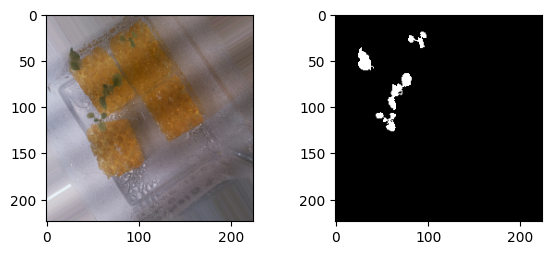

In [5]:
r = random.randint(0, len(x)-1)

fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(x[r])
ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(y[r], (dim, dim)), cmap="gray")

## Different Convolutional Blocks

In [6]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

## UNet Model

In [7]:
def UNet(image_size):
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((image_size, image_size, 3))
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #128 -> 64
    c2, p2 = down_block(p1, f[1]) #64 -> 32
    c3, p3 = down_block(p2, f[2]) #32 -> 16
    c4, p4 = down_block(p3, f[3]) #16->8
    
    bn = bottleneck(p4, f[4])
    
    u1 = up_block(bn, c4, f[3]) #8 -> 16
    u2 = up_block(u1, c3, f[2]) #16 -> 32
    u3 = up_block(u2, c2, f[1]) #32 -> 64
    u4 = up_block(u3, c1, f[0]) #64 -> 128
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
    model = keras.models.Model(inputs, outputs)
    return model

## Loss Function

In [8]:
#from keras import saving

# @keras.saving.register_keras_serializable()
def weighted_bincrossentropy(true, pred):
    """
    Calculates weighted binary cross entropy. The weights are fixed.
        
    This can be useful for unbalanced catagories.
    
    Adjust the weights here depending on what is required.
    
    For example if there are 10x as many positive classes as negative classes,
        if you adjust weight_zero = 1.0, weight_one = 0.1, then false positives 
        will be penalize 10 times as much as false negatives.
    """
    # y = keras.backend.flatten(true)
    # r = np.max(((keras.backend.sum(y).numpy()/dim**2)**3, 1e-8))
    # calculate the binary cross entropy
    bin_crossentropy = keras.backend.binary_crossentropy(true, pred)
    
    # apply the weights
    weights = true * np.log(13) + (1. - true) * 0.5
    weighted_bin_crossentropy = weights * bin_crossentropy 

    return keras.backend.mean(weighted_bin_crossentropy)

# @keras.saving.register_keras_serializable()
def mean_iou_loss(y_true, y_pred):

    pred_sum = keras.backend.sum(y_pred)
    gt_sum = keras.backend.sum(y_true)
    intersection = keras.backend.sum(tf.math.multiply(y_true,y_pred))
    
    union = pred_sum + gt_sum - intersection

    iou = intersection/union
    return 1 - iou

# @keras.saving.register_keras_serializable()
def dice_coef(y_true, y_pred, smooth=1):
    y_pred = tf.cast(y_pred, tf.float32)
    y_true = tf.cast(y_true, tf.float32)
    intersection = keras.backend.sum(y_true * y_pred, axis=[1,2,3])
    union = keras.backend.sum(y_true, axis=[1,2,3]) + keras.backend.sum(y_pred, axis=[1,2,3])
    return keras.backend.mean( (2. * intersection + smooth) / (union + smooth), axis=0)

# @keras.saving.register_keras_serializable()
def dice_loss(in_gt, in_pred):
    return 1 - dice_coef(in_gt, in_pred)

# @keras.saving.register_keras_serializable()
def dice_p_bce(in_gt, in_pred):
    """combine DICE and BCE"""
    # 0.01*keras.losses.binary_crossentropy(in_gt, in_pred)
    return 0.01*weighted_bincrossentropy(in_gt, in_pred) + (1- dice_coef(in_gt, in_pred))

# @keras.saving.register_keras_serializable()
def true_positive_rate(y_true, y_pred):
    return keras.backend.sum(keras.backend.flatten(y_true)*keras.backend.flatten(keras.backend.round(y_pred)))/keras.backend.sum(y_true)

# @keras.saving.register_keras_serializable()
def dice_mean_iou(in_gt, in_pred):
    return (dice_loss(in_gt, in_pred) + mean_iou_loss(in_gt, in_pred)) / 2




In [9]:
model = UNet(dim)

learning_rate = 0.0001
opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
# opt = tf.keras.optimizers.SGD(learning_rate = 0.00001)
# model.compile(optimizer = opt, loss=weighted_bincrossentropy, metrics=["acc"])
cce = keras.losses.CategoricalFocalCrossentropy()

use_loss = dice_mean_iou
print(use_loss.__name__)
model.compile(optimizer = opt, loss=use_loss, metrics=[dice_coef, 'binary_accuracy', dice_p_bce, dice_loss, true_positive_rate, weighted_bincrossentropy])
model.summary()

dice_mean_iou


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 224, 224,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 224, 224,  │      2,320 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 112, 112,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 112, 112,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 112, 112,  │      9,248 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 56, 56,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 56, 56,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 56, 56,    │     36,928 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 28, 28,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 28, 28,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 28, 28,    │    147,584 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 14, 14,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 14, 14,    │    295,168 │ max_pooling2d_3[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 14, 14,    │    590,080 │ conv2d_8[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 28, 28,    │          0 │ conv2d_9[0][0]    │
│ (UpSampling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 28, 28,    │          0 │ up_sampling2d[0]

 Total params: 1,962,625 (7.49 MB)

 Trainable params: 1,962,625 (7.49 MB)

 Non-trainable params: 0 (0.00 B)

## Training the model

In [10]:
train_gen = DataGen(train_imgs, train_masks, batch_size= batch_size, hls = False)
valid_gen = DataGen(test_imgs, test_masks, batch_size=batch_size, hls = False)

# from sklearn.utils import class_weight
x, y = train_gen.__getitem__(5)

w1s = []
w2s = []
for i in y:
    i = np.reshape(i, (dim,dim))
    if np.sum(i) != 0:
        w1s.append(dim**2/(2 * np.sum(i)) )
        w2s.append(dim**2/(2 * (dim**2 - sum(i))))

print(np.mean(w1s), np.mean(w2s))


rs = []
for i in range(len(train_gen)):
    _, masks = train_gen.__getitem__(i)

    for j in masks:
        j = np.reshape(j, (dim,dim))
        r = sum(j > 0.5) / dim**2
        rs.append(r)

r = np.mean(rs)
print(r)

20.169705912966954 0.50007147
0.00012771265383943755


In [11]:
model_num = 14

In [12]:

history = model.fit(train_gen, batch_size=batch_size, epochs = 1000, validation_data= valid_gen) 

Epoch 1/1000


C:\Users\chloe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
C:\Users\chloe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 4s/step - binary_accuracy: 0.9609 - dice_coef: 0.0554 - dice_loss: 0.9446 - dice_p_bce: 0.9484 - loss: 0.9578 - true_positive_rate: 4.8872e-04 - weighted_bincrossentropy: 0.3747 - val_binary_accuracy: 0.9595 - val_dice_coef: 0.0593 - val_dice_loss: 0.9407 - val_dice_p_bce: 0.9444 - val_loss: 0.9547 - val_true_positive_rate: 2.4639e-04 - val_weighted_bincrossentropy: 0.3710
Epoch 2/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 24s 4s/step - binary_accuracy: 0.9633 - dice_coef: 0.0538 - dice_loss: 0.9462 - dice_p_bce: 0.9498 - loss: 0.9590 - true_positive_rate: 2.8442e-04 - weighted_bincrossentropy: 0.3636 - val_binary_accuracy: 0.9635 - val_dice_coef: 0.0602 - val_dice_loss: 0.9398 - val_dice_p_bce: 0.9434 - val_loss: 0.9540 - val_true_positive_rate: 1.6711e-04 - val_weighted_bincrossentropy: 0.3606
Epoch 3/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - binary_accuracy: 0.9667 - dice_coef: 0.0555 - dice_loss: 0.9445 - dice_p_bce: 0.9480 - loss: 0.9576 - true_positive_rate: 0.0

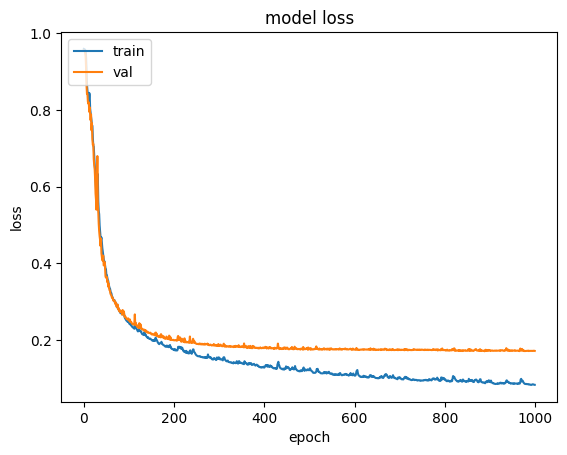

In [13]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

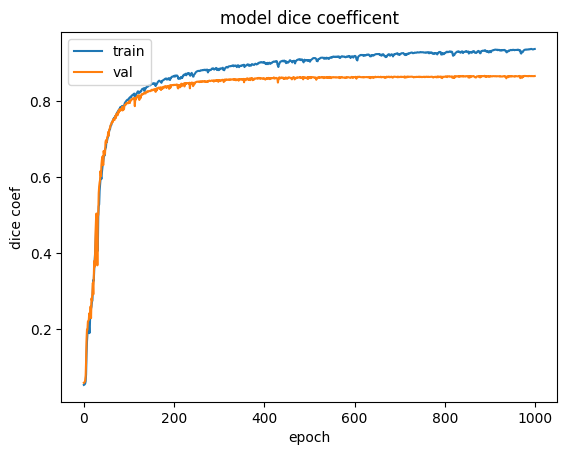

In [14]:
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.title('model dice coefficent')
plt.ylabel('dice coef')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [15]:
# print("Max acc:", round(max(history.history['acc']),4))
# print("Max val_acc:", round(max(history.history['val_acc']),4))
# print("\nMin loss:", round(min(history.history['loss']),4))
# print("Min val_loss:", round(min(history.history['val_loss']),4))

## Testing the model

In [16]:
## Save the Weights

#model.save_weights("UNetW.h5")

In [17]:
## Dataset for prediction
x, y = valid_gen.__getitem__(0)
result = model.predict(x)

result = result > 0.5

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 973ms/step


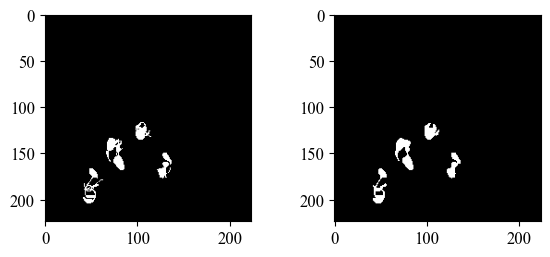

In [26]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

r = random.randint(0, len(x)-1)


ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[r]*255, (dim, dim)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[r]*255, (dim, dim)), cmap="gray")

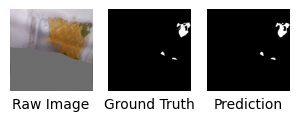

In [19]:
fig, axes = plt.subplots(ncols = 3, )

fig.set_figwidth(3.6)
fig.set_figheight(2)


axes[0].imshow(x[0])
axes[0].set_xlabel('Raw Image')
axes[1].imshow(np.reshape(y[0]*255, (dim, dim)), cmap="gray")
axes[1].set_xlabel('Ground Truth')
axes[2].imshow(np.reshape(result[0]*255, (dim, dim)), cmap="gray")
axes[2].set_xlabel('Prediction')

matplotlib.rcParams.update({'font.size': 12, "font.family": "Times New Roman"})

for i, ax in enumerate(axes):
    axes[i].tick_params(
        axis='both',          # changes apply to the voth axis
        which='both', 
        left = False,   # both major and minor ticks are affected
        right = False,
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off
    
    axes[i].xaxis.set_ticklabels([])
    axes[i].yaxis.set_ticklabels([])

    for j in ax.spines:
        axes[i].spines[j].set_visible(False)
        
    plt.savefig(rf'C:\Users\chloe\DE4\Masters\Models\Model_{model_num}_example.pdf', dpi =300)



## Save Model

In [20]:
import json


In [21]:
# !mkdir saved_models
# model.save(r'C:\Users\thoma\Desktop\CT_Segment_Full_v2.h5')

model.save(rf'C:\Users\chloe\DE4\Masters\Models\Model_{model_num}.keras')


save_dict = {'History': history.history, 'Loss Function': use_loss.__name__, 'Learning Rate': learning_rate, 'Num Training Images': len(train_imgs), 'Num Test Images': len(test_imgs), 'Batch Size': batch_size}

with open(rf'C:\Users\chloe\DE4\Masters\Models\Model_{model_num}_history.json', 'w') as f:
    json.dump(save_dict, f)


In [22]:
# with open(r'C:\Users\chloe\DE4\Masters\Models\Model_3_history.pkl', 'r') as f:
#     hist = json.load(f)

# print(len(hist['History']['binary_accuray']))

